# Using a Webcam as input source of the Composable Pipeline
----

<div class="alert alert-box alert-info">
Please use Jupyter labs http://&lt;board_ip_address&gt;/lab for this notebook.
</div>

This notebook shows your how to use a Webcam as a input source for your composable pipeline

## Aims
* Use Webcam as an input video source
* Compose a video pipeline over the webcam stream

## Table of Contents
* [Download Composable Overlay](#download)
* [Configure Webcam](#setup_cam)
* [Compose a Simple Pipeline](#simple-pipeline)
* [Compose Complex Pipeline](#complex-pipeline)
* [Modify Parameters](#parameters)
* [Stop Webcam Video](#stop_web)
* [Conclusion](#conclusion)

----

## Revision History

* v1.0 | 21 June 2021 | First notebook revision.
* v1.1 | 11 August 2021 | Update notebook to composable overlay API 1.0.0
* v1.2 | 27 September 2021 | Update notebook to use `VideoStream`

----

## Download Composable Overlay <a class="anchor" id="download"></a>

Import the pynq video libraries as well as Composable class and the drivers for the IP.

Download the Composable Overlay using `pynq.Overlay` and grab a handler to the `composable` hierarchy

In [1]:
from pynq import Overlay
from pynq.lib.video import *
from pynq_composable import *
from ipywidgets import widgets, interact, FloatSlider, IntSlider
from pynq.ps import CPU_ARCH, ZYNQ_ARCH

ol = Overlay("cv_dfx_4_pr.bit")

cpipe = ol.composable

## Configure Webcam <a class="anchor" id="setup_cam"></a>

Configure the Webcam and with `VideoStream` class, and start the video

<div class="alert alert-heading alert-danger">
    <h4 class="alert-heading">Warning:</h4>

Failure to connect HDMI output cable to an screen may cause the notebook to hang
</div>

In [2]:
video = VideoStream(ol, source=VSource.OpenCV)

video.start()

## Compose Simple Pipeline <a class="anchor" id="simple-pipeline"></a>

Grab handlers to LUT and compose

In [3]:
lut = cpipe.lut_accel
lut.kernel_type = xvLut.negative

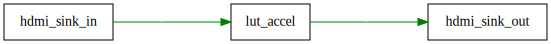

In [4]:
cpipe.compose([cpipe.hdmi_sink_in, lut, cpipe.hdmi_sink_out])
cpipe.graph

## Compose Complex Pipeline <a class="anchor" id="complex-pipeline"></a>

<div class="alert alert-heading alert-danger">
    <h4 class="alert-heading">Warning:</h4>

Failure to pause the VideoStream for Zynq-7000 devices before using `.loadIP` may cause the notebook to hang
</div>

In this part of the notebook, we will bring new functionality into the DFX regions to compose a corner detect application. 

Load dynamic IP, grab handlers and set up default values

In [5]:
if CPU_ARCH != ZYNQ_ARCH:
    video.pause()

cpipe.loadIP(['pr_0/fast_accel', 'pr_fork/duplicate_accel', 'pr_join/add_accel'])

In [6]:
#Resume Webcam stream
if CPU_ARCH != ZYNQ_ARCH:
    video.start()

Grab handler to functions

In [7]:
fast = cpipe.pr_0.fast_accel
duplicate = cpipe.pr_fork.duplicate_accel
add = cpipe.pr_join.add_accel
r2g = cpipe.rgb2gray_accel
g2r = cpipe.gray2rgb_accel

The Corner Detect is realized by adding (masking) the output of the Fast algorithm to the original image. In the Composable Overlay this is achieved by branching the pipeline, which is expressed as a list of a list.

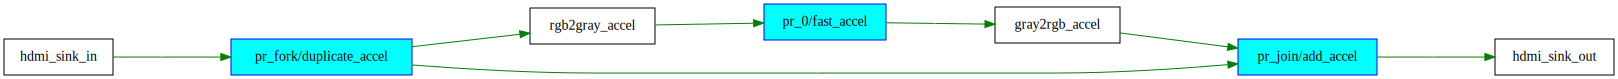

In [8]:
video_pipeline = [cpipe.hdmi_sink_in, duplicate, [[r2g, fast, g2r], [1]], add, cpipe.hdmi_sink_out]

cpipe.compose(video_pipeline)

cpipe.graph

## Modify Parameters <a class="anchor" id="parameters"></a>

The corner Harris IP provides two parameters that help us tweak the sensitivity of the algorithm. These parameters are the threshold and k (Harris parameter), after running the next cell you will be able to update them.

In [10]:
thr = IntSlider(min=0, max=255, step=1, value=25)
def play(thr):
    fast.threshold = thr

interact(play, thr=thr);

interactive(children=(IntSlider(value=25, description='thr', max=255), Output()), _dom_classes=('widget-intera…

## Stop Webcam Video <a class="anchor" id="stop_web"></a>

Finally stop the video stream

<div class="alert alert-heading alert-danger">
    <h4 class="alert-heading">Warning:</h4>

Failure to stop video stream may hang the board 
when trying to download another bitstream onto the FPGA
</div>

In [ ]:
video.stop()
ol.free()

----

## Conclusion <a class="anchor" id="conclusion"></a>

This notebook has shown how to compose a video pipeline using a Webcam as a video source

[⬅️ Advanced Features](07_advanced_features.ipynb) | | 

Copyright &copy; 2021 Xilinx, Inc

SPDX-License-Identifier: BSD-3-Clause

----